# Installing and importing libraries/modules

In [ ]:
# Installing the requirements
print('Installing Requirements... ',end='')
!pip install lightning
print('Done')

Installing Requirements... Collecting lightning
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 51.7 MB/s eta 0:00:00
Done


In [ ]:
# Importing Libraries
print('Importing Libraries... ',end='')
import os
import torch
import torchaudio
import torch.nn as nn
import pandas as pd
import numpy as np
import zipfile
from tqdm import tqdm
from pathlib import Path
import IPython.display as ipd
import matplotlib.pyplot as plt
from torchsummary import summary
import pytorch_lightning as pl
from torchaudio.transforms import Resample
from torch.utils.data import Dataset, DataLoader
print('Done')

Importing Libraries... Done


In [ ]:
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data loading and visualization (spectrogram)

**Introduction to Dataset**

The data has a total of 10 classes with 40 samples each.While working with the data, we nedd to make sure that **esc10=True**. In the assignment, we are required to perform 4-fold validation. This dataset has been already divided into 5-folds. The column 'fold' in the metafile denotes the sample in a particular fold. Moreover, first folds is considered for test, rest for 4-fold validation.

## Load and listen the Audio-data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extract data
with zipfile.ZipFile("/content/drive/MyDrive/DL Assignment2/Archive.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [ ]:
# Loading dataset
path = Path('/content/')
df = pd.read_csv('/content/meta/esc50.csv')

Shape of waveform: torch.Size([1, 220500])
Sample rate of waveform: 44100 Hz


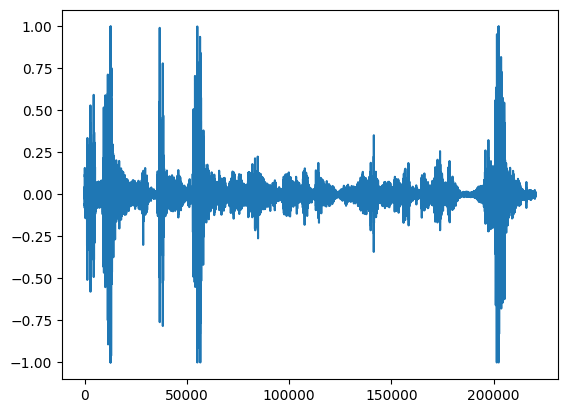

In [ ]:
# Getting list of raw audio files
wavs = list(path.glob('audio/*'))  # List all audio files in the 'audio' directory using pathlib.Path.glob

# Visualizing data
waveform, sample_rate = torchaudio.load(wavs[102])  # Load the waveform and sample rate of the first audio file using torchaudio

print("Shape of waveform: {}".format(waveform.size()))  # Print the shape of the waveform tensor
print("Sample rate of waveform: {} Hz".format(sample_rate))  # Print the sample rate of the audio file

# Plot the waveform using matplotlib
plt.figure()
plt.plot(waveform.t().numpy())  # Transpose and convert the waveform tensor to a NumPy array for plotting

# Display the audio using IPython.display.Audio
ipd.Audio(waveform, rate=sample_rate)  # Create an interactive audio player for the loaded waveform


In [ ]:
# Let's check the number of audio files at this stage of code
len(wavs)

2000

In [ ]:
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


# Data preprocessing

In [ ]:
df_copy = df[df["esc10"] == True]
df_copy.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
24,1-116765-A-41.wav,1,41,chainsaw,True,116765,A
54,1-17150-A-12.wav,1,12,crackling_fire,True,17150,A
55,1-172649-A-40.wav,1,40,helicopter,True,172649,A


In [ ]:
min(df_copy['target'].values), max(df_copy['target'].values)

(0, 41)

In [ ]:
len(df_copy)

400

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset, **kwargs):
        # Initialize CustomDataset object with relevant parameters
        # dataset: "train", "val", or "test"
        # kwargs: Additional parameters like data directory, dataframe, folds, etc.

        # Extract parameters from kwargs
        self.data_directory = kwargs["data_directory"]
        self.data_frame = kwargs["data_frame"]
        self.validation_fold = kwargs["validation_fold"]
        self.testing_fold = kwargs["testing_fold"]
        self.esc_10_flag = kwargs["esc_10_flag"]
        self.file_column = kwargs["file_column"]
        self.label_column = kwargs["label_column"]
        self.sampling_rate = kwargs["sampling_rate"]
        self.new_sampling_rate = kwargs["new_sampling_rate"]
        self.sample_length_seconds = kwargs["sample_length_seconds"]

        # Filter dataframe based on esc_10_flag and data_type
        if self.esc_10_flag:
            self.data_frame = self.data_frame.loc[self.data_frame['esc10'] == True]

        if dataset == "train":
            self.data_frame = self.data_frame.loc[
                (self.data_frame['fold'] != self.validation_fold) & (self.data_frame['fold'] != self.testing_fold)]
        elif dataset == "val":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.validation_fold]
        elif dataset == "test":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.testing_fold]

        # Get unique categories from the filtered dataframe
        self.categories = sorted(self.data_frame[self.label_column].unique())

        # Initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []

        # Initialize dictionaries for category-to-index and index-to-category mapping
        self.category_to_index = {}
        self.index_to_category = {}

        for i, category in enumerate(self.categories):
            self.category_to_index[category] = i
            self.index_to_category[i] = category

        # Populate file names and labels lists by iterating through the dataframe
        for ind in tqdm(range(len(self.data_frame))):
            row = self.data_frame.iloc[ind]
            file_path = self.data_directory / "audio" / row[self.file_column]
            self.file_names.append(file_path)
            self.labels.append(self.category_to_index[row[self.label_column]])

        self.resampler = torchaudio.transforms.Resample(self.sampling_rate, self.new_sampling_rate)

        # Window size for rolling window sample splits (unfold method)
        if self.sample_length_seconds == 2:
            self.window_size = self.new_sampling_rate * 2
            self.step_size = int(self.new_sampling_rate * 0.75)
        else:
            self.window_size = self.new_sampling_rate
            self.step_size = int(self.new_sampling_rate * 0.5)

    def __getitem__(self, index):
        # Split audio files with overlap, pass as stacked tensors tensor with a single label
        path = self.file_names[index]
        audio_file = torchaudio.load(path, format=None, normalize=True)
        audio_tensor = self.resampler(audio_file[0])
        splits = audio_tensor.unfold(1, self.window_size, self.step_size)
        samples = splits.permute(1, 0, 2)

        return samples, self.labels[index]

    def __len__(self):
        return len(self.file_names)


**Why is Resampling performed (new sampling rate significance)?**

# Dataloaders and Setup

In [ ]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, **kwargs):
        # Initialize the CustomDataModule with batch size, number of workers, and other parameters
        super().__init__()
        self.batch_size = kwargs["batch_size"]
        self.num_workers = kwargs["num_workers"]
        self.data_module_kwargs = kwargs

    def setup(self, stage=None):
        # Define datasets for training, validation, and testing during Lightning setup

        # If in 'fit' or None stage, create training and validation datasets
        if stage == 'fit' or stage is None:
            self.training_dataset = CustomDataset(dataset="train", **self.data_module_kwargs)
            self.validation_dataset = CustomDataset(dataset="val", **self.data_module_kwargs)

        # If in 'test' or None stage, create testing dataset
        if stage == 'test' or stage is None:
            self.testing_dataset = CustomDataset(dataset="test", **self.data_module_kwargs)


    def train_dataloader(self):
        # Return DataLoader for training dataset
        return DataLoader(self.training_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        # Return DataLoader for validation dataset
        return DataLoader(self.validation_dataset,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        # Return DataLoader for testing dataset
        return DataLoader(self.testing_dataset,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers)

In [ ]:
# Data Setup
test_samp = 1  # Do not change this!!
valid_samp_list = [2, 3, 4, 5]   # For 4-fold validation
batch_size = 32 # Free to change
num_workers = 8 # Free to change
data_modules, train_loaders, val_loaders = [], [], []

# # Perform 4-fold cross-validation
def kFold_validation():
    for valid_samp in valid_samp_list:
        print(f"\nFold {valid_samp} for validation set")
        custom_data_module = CustomDataModule(batch_size=batch_size,
                                              num_workers=num_workers,
                                              data_directory=path,
                                              data_frame=df,
                                              validation_fold=valid_samp,
                                              testing_fold=test_samp,
                                              esc_10_flag=True,
                                              file_column='filename',
                                              label_column='category',
                                              sampling_rate=44100,
                                              new_sampling_rate=16000,  # new sample rate for input
                                              sample_length_seconds=3
                                              )

        data_modules.append(custom_data_module)
        custom_data_module.setup()

        train_loader = custom_data_module.train_dataloader()
        val_loader = custom_data_module.val_dataloader()

        train_loaders.append(train_loader)
        val_loaders.append(val_loader)

    return data_modules, train_loaders, val_loaders

print("\nInput audio signal downsampled to 16000 by giving new sampling rate (default value)")



Input audio signal downsampled to 16000 by giving new sampling rate (default value)


In [ ]:
kFold_validation()


Fold 2 for validation set


100%|██████████| 80/80 [00:00<00:00, 10245.00it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Fold 3 for validation set


100%|██████████| 80/80 [00:00<00:00, 10270.72it/s]



Fold 4 for validation set


100%|██████████| 80/80 [00:00<00:00, 9930.58it/s]



Fold 5 for validation set


100%|██████████| 80/80 [00:00<00:00, 5402.77it/s]


([<__main__.CustomDataModule at 0x7b04108c9c90>,
  <torch.utils.data.dataloader.DataLoader at 0x7b04108b3820>])

In [ ]:
# Data Exploration
print('Class Label: ', data_modules[0].training_dataset[0][1])  # this prints the class label
print('Shape of data sample tensor: ', data_modules[0].training_dataset[0][0].shape)  # this prints the shape of the sample (Frames, Channel, Features)

Class Label:  2
Shape of data sample tensor:  torch.Size([9, 1, 16000])


In [ ]:
#Dataloader(s)
train_loader1_lst = next(iter(train_loaders[0]))
train_loader2_lst = next(iter(train_loaders[1]))
train_loader3_lst = next(iter(train_loaders[2]))
train_loader4_lst = next(iter(train_loaders[3]))

val_loader1_lst = next(iter(val_loaders[0]))
val_loader2_lst = next(iter(val_loaders[1]))
val_loader3_lst = next(iter(val_loaders[2]))
val_loader4_lst = next(iter(val_loaders[3]))

test_loader = data_modules[0].test_dataloader()
test_loader_lst = next(iter(test_loader))

print('Train Dataloader1:')
print(train_loader1_lst)

# # print('\nValidation Dataloader1:')
# # print(val_loader1_lst)

# # print('\nTest Dataloader:')
# # print(test_loader_lst)

Train Dataloader1:
[tensor([[[[ 6.7424e-04,  1.4866e-03,  1.6327e-03,  ...,  3.5793e-04,
            5.4382e-05,  1.5191e-04]],

         [[-1.6597e-02,  5.4035e-03, -8.8937e-04,  ...,  1.7729e-04,
           -3.0781e-04, -2.9740e-04]],

         [[ 6.9322e-04,  7.4417e-04, -7.1669e-05,  ...,  9.2279e-04,
            6.6245e-05, -1.0892e-04]],

         ...,

         [[-6.6911e-05, -2.9718e-04, -2.1920e-04,  ...,  2.5588e-04,
            1.5796e-04,  1.2444e-04]],

         [[-2.9344e-02, -3.4412e-02, -2.4627e-02,  ...,  1.2270e-02,
            4.1782e-03, -7.2657e-03]],

         [[ 7.6899e-04,  1.3720e-03,  1.5745e-03,  ...,  3.4339e-04,
            5.7527e-05,  2.4171e-04]]],


        [[[-1.6923e-01, -2.5859e-01, -2.3690e-01,  ...,  4.7125e-01,
            4.4501e-01,  4.2710e-01]],

         [[ 1.6888e-01,  8.2256e-02, -4.4938e-03,  ...,  4.5159e-01,
            4.9999e-01,  3.9282e-01]],

         [[ 2.4503e-01,  1.0130e-01,  1.8732e-01,  ..., -5.4268e-02,
           -1.0696e-01

In [ ]:
train_loader1_lst[0].size(), test_loader_lst[0].size()

(torch.Size([32, 9, 1, 16000]), torch.Size([32, 9, 1, 16000]))

In [ ]:
train_loader1_lst[0].squeeze().size()

torch.Size([32, 9, 16000])

# **Network Architecture**:

**Architecture 1:**

Use **1D-convolution for feature extraction**. The base network should be **at least three layers**
deep. On top of it implement a fully-connected layer for multi-class classification. Use any number of layers, strides, kernel size, number of filters, activation functions,
pooling, and other free parameters. **Pytorch only**.

**Architecture 2:**

● Use **1D-convolution for feature extraction**. Use the **same base network** as above. On top
of the base network, implement a transformer encoder network (from scratch) with a
multi-head self-attention mechanism. **Make sure to add the ```<cls>``` token**. On the top of
the transformer, an MLP head should be there for classification. Model should have
**at least two attention blocks for number of heads = 1,2,4.**

● Prepare a detailed analysis, which model achieves best accuracy and why?

● The **self-attention is to be implemented by scratch** to solve a 10-class classification
problem using Pytorch. Use Pytorch/Pytorch Lightning.

**Tasks:**

1. Train for **100 epochs**. Plot accuracy and loss per epoch on Weight and Biases (WandB) platform. Also, mention plots in the report.

2. Perform k-fold validation, for **k=4**.

3. Prepare an **Accuracy, Confusion matrix, F1-scores, and AUC-ROC curve** for the test set **for all the combinations** of the network. In-built function allowed for this purpose.

4. Report total trainable and non-trainable parameters.

5. Perform **hyper-parameter tuning and report the best hyper-parameter set**.
Perform all tasks for both architectures with both test-split configurations and k-fold validation strategies.

# Architecture 1

## Build the base network

In [ ]:
# Build CNN class
class feedforward(nn.Module):
    def __init__(self, num_classes, dropout=0.1):
        super(feedforward, self).__init__()

        # Layer 1
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=9, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(dropout, inplace=True)
        )

        # Layer 2
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(dropout, inplace=True)
        )

        # Layer 3
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(dropout, inplace=True)
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1*2000*64, num_classes)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, out):
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.flatten(out)
        out = self.fc1(out)
        # out = self.softmax(out)
        return out

## Create Model

In [ ]:
torch.manual_seed(42)
if torch.cuda.is_available():
   torch.cuda.manual_seed(42)

model1 = feedforward(10).to(device)
model1

feedforward(
  (conv1): Sequential(
    (0): Conv1d(9, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=True)
  )
  (flatten): Flatte

In [ ]:
model1.parameters()

<generator object Module.parameters at 0x7b041070f990>

In [ ]:
summary(model1, (9, 16000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 16, 16000]             448
              ReLU-2            [-1, 16, 16000]               0
       BatchNorm1d-3            [-1, 16, 16000]              32
         MaxPool1d-4             [-1, 16, 8000]               0
           Dropout-5             [-1, 16, 8000]               0
            Conv1d-6             [-1, 32, 8000]           1,568
              ReLU-7             [-1, 32, 8000]               0
       BatchNorm1d-8             [-1, 32, 8000]              64
         MaxPool1d-9             [-1, 32, 4000]               0
          Dropout-10             [-1, 32, 4000]               0
           Conv1d-11             [-1, 64, 4000]           6,208
             ReLU-12             [-1, 64, 4000]               0
      BatchNorm1d-13             [-1, 64, 4000]             128
        MaxPool1d-14             [-1, 6

## Optimizer, loss function and Hyperparameters

In [ ]:
# learning rate, device and number of iterations for training
lr, epochs = 0.001, 20
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(params=model1.parameters(), lr=lr)

## Train the model

In [ ]:
def train_model(model, train_loaders_list, val_loaders_list, optimizer):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    avg_train_losses, avg_val_losses, avg_train_acc, avg_val_acc = [], [], [], []

    # # Set seed
    # torch.manual_seed(42)
    # if torch.cuda.is_available():
    #     torch.cuda.manual_seed(42)

    for i in range(4):
        print(f"For Fold {i+2}:\n")
        for epoch in range(epochs):
            model.train()
            current_loss, total, correct = 0.0, 0, 0
            for x, y in train_loaders_list[i]:
                x = x.squeeze()
                x, y = x.to(device), y.to(device)
                preds = model(x)
                loss = criterion(preds, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                current_loss += loss.item()
                _, predicted = torch.max(preds.data, 1)
                total += y.size(0)
                correct += torch.sum(predicted == y).item()   # to convert from torch scalar into normal scalar value

            # Train loss and accuracy
            train_losses.append(current_loss/ len(train_loaders_list[i]))
            train_acc = correct*100 / total
            train_accuracies.append(train_acc)

            # Evaluate on the validation set
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                model.eval()
                for x, y in val_loaders_list[i]:
                    x = x.squeeze()
                    x, y = x.to(device), y.to(device)
                    val_preds = model(x)
                    loss = criterion(val_preds, y)
                    val_loss += loss.item() #* len(y)
                    _, predicted = torch.max(val_preds.data, 1)
                    val_total += y.size(0)
                    val_correct += torch.sum(predicted == y).item()   # to convert from torch scalar into normal scalar value

                # Validation loss and accuracy
                val_losses.append(val_loss/ len(val_loaders_list[i]))
                val_acc = val_correct*100 / val_total
                val_accuracies.append(val_acc)

            if(epoch%5 == 0):
                print("\033[1m" + f"Epoch [{epoch + 1}/{epochs}]: ")
                print(f"\nTrain Loss: {train_losses[-1]:.4f}, "
                      f"Training Accuracy: {train_acc:.4f} %")
                print(f"\nValidation Loss: {val_losses[-1]:.4f}, "
                      f"Validation Accuracy: {val_acc:.4f} %")
                print("---------------------------------------------------------------------------")

        avg_train_losses.append(np.mean(train_losses[i*epochs:(i+1)*epochs]))
        avg_val_losses.append(np.mean(val_losses[i*epochs:(i+1)*epochs]))
        avg_train_acc.append(np.mean(train_accuracies[i*epochs:(i+1)*epochs]))
        avg_val_acc.append(np.mean(val_accuracies[i*epochs:(i+1)*epochs]))

    print("Average training loss =", np.mean(avg_train_losses))
    print("\nAverage validation loss =", np.mean(avg_val_losses))
    print("\nAverage training accuracy =", np.mean(avg_train_acc))
    print("\nAverage validation accuracy =", np.mean(avg_val_acc))
    print("\nTraining done!")

    return train_losses, val_losses, train_accuracies, val_accuracies, avg_train_losses, avg_val_losses, avg_train_acc, avg_val_acc

In [ ]:
train_losses1, val_losses1, train_accuracies1, val_accuracies1, avg_train_losses1, avg_val_losses1, avg_train_acc1, avg_val_acc1 = train_model(model1, train_loaders, val_loaders, optimizer1)

For Fold 2:



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/20]: 

Train Loss: 24.4885, Training Accuracy: 22.9167 %

Validation Loss: 21.5357, Validation Accuracy: 10.0000 %
---------------------------------------------------------------------------
Epoch [6/20]: 

Train Loss: 0.3595, Training Accuracy: 95.8333 %

Validation Loss: 10.6765, Validation Accuracy: 25.0000 %
---------------------------------------------------------------------------
Epoch [11/20]: 

Train Loss: 0.0386, Training Accuracy: 99.1667 %

Validation Loss: 9.4489, Validation Accuracy: 40.0000 %
---------------------------------------------------------------------------
Epoch [16/20]: 

Train Loss: 0.0173, Training Accuracy: 99.1667 %

Validation Loss: 7.2309, Validation Accuracy: 47.5000 %
---------------------------------------------------------------------------
For Fold 3:

Epoch [1/20]: 

Train Loss: 2.7146, Training Accuracy: 80.8333 %

Validation Loss: 0.0001, Validation Accuracy: 100.0000 %
-------------------------------------------------------------------

## Test Accuracy

In [ ]:
test_loader_lst[0].shape

torch.Size([32, 9, 1, 16000])

In [ ]:
def test_accuracy(model, test_loader):
    # torch.manual_seed(42)
    # if torch.cuda.is_available():
    #    torch.cuda.manual_seed(42)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.squeeze()
            x, y = x.to(device), y.to(device)
            preds = model(x)
            _, predicted = torch.max(preds.data, 1)
            total += y.size(0)
            correct += torch.sum(predicted == y).item()   # to convert from torch scalar into normal scalar value

    # Test accuracy
    test_acc = correct*100 / total

    return test_acc

In [ ]:
test_acc1 = test_accuracy(model1, test_loader)
print(f"Test accuracy of model1 is {test_acc1} %")

Test accuracy of model1 is 50.0 %


## Epochs vs Loss curve

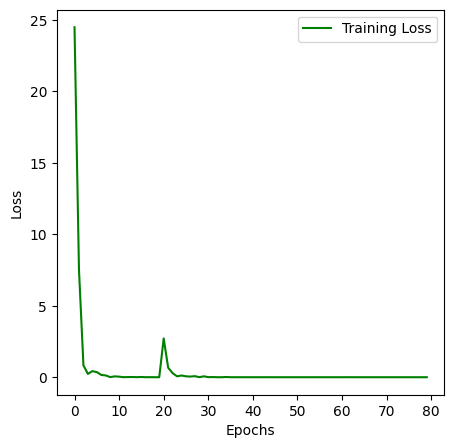

In [ ]:
# For training set
plt.figure(figsize=(5, 5))
plt.plot(train_losses1, label='Training Loss', c='g')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

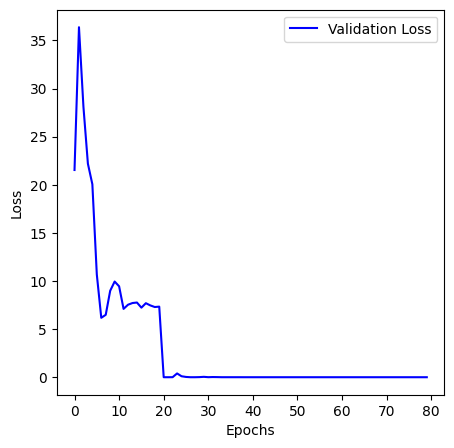

In [ ]:
# For validation set
plt.figure(figsize=(5, 5))
plt.plot(val_losses1, label='Validation Loss', c='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Architecture 2

● Use **1D-convolution for feature extraction**. Use the **same base network** as above. On top
of the base network, implement a transformer encoder network (from scratch) with a
multi-head self-attention mechanism. **Make sure to add the ```<cls>``` token**. On the top of
the transformer, an MLP head should be there for classification. Model should have
**at least two attention blocks for number of heads = 1,2,4.**

● Prepare a detailed analysis, which model achieves best accuracy and why?

● The self-attention is to be implemented by scratch to solve a 10-class classification problem using Pytorch. Use Pytorch/Pytorch Lightning.

## Transformer building

### Base network

In [ ]:
class Conv1DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(Conv1DBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

### Single encoder block

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.linear1 = nn.Linear(embed_dim, 4 * embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(4 * embed_dim, embed_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x, mask=None):
        x_norm = self.norm1(x)
        attn_output, _ = self.self_attn(x_norm, x_norm, x_norm, attn_mask=mask)
        x = x + self.dropout(attn_output)
        x_norm = self.norm2(x)
        x = x + self.dropout(self.linear2(self.dropout(nn.functional.relu(self.linear1(x_norm)))))
        return x

### Encoder only Transformer

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, embed_dim, num_heads):
        super(TransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([TransformerEncoderLayer(embed_dim, num_heads) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask=mask)
        return x

### Transformer classifier

In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_size, num_classes, num_conv_layers=3, num_transformer_layers=2, embed_dim=128, num_heads=1):
        super(TransformerClassifier, self).__init__()
        self.conv_layers = nn.ModuleList([Conv1DBlock(input_size if i == 0 else embed_dim, embed_dim, kernel_size=3, padding=1) for i in range(num_conv_layers)])
        self.transformer_encoder = TransformerEncoder(num_layers=num_transformer_layers, embed_dim=embed_dim, num_heads=num_heads)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x, mask=None):
        for conv_layer in self.conv_layers:
            x = conv_layer(x)

        x = x.permute(0, 2, 1)  # Change to (batch_size, seq_len, embed_dim) for transformer
        x = self.transformer_encoder(x, mask=mask)
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc(x)
        return x

### Training transformer models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
criterion = nn.CrossEntropyLoss()
epochs = 20

In [ ]:
def train_transformer(model, train_loaders_list, val_loaders_list, optimizer):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    avg_train_losses, avg_val_losses, avg_train_acc, avg_val_acc = [], [], [], []

    # # Set seed
    # torch.manual_seed(42)
    # if torch.cuda.is_available():
    #     torch.cuda.manual_seed(42)

    for i in range(4):
        print(f"For Fold {i+2}:\n")
        for epoch in range(epochs):
            model.train()
            current_loss, total, correct = 0.0, 0, 0
            for x, y in train_loaders_list[i]:
                x = x.squeeze()
                x, y = x.to(device), y.to(device)
                preds = model(x)
                loss = criterion(preds, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                current_loss += loss.item()
                _, predicted = torch.max(preds.data, 1)
                total += y.size(0)
                correct += torch.sum(predicted == y).item()   # to convert from torch scalar into normal scalar value

            # Train loss and accuracy
            train_losses.append(current_loss/ len(train_loaders_list[i]))
            train_acc = correct*100 / total
            train_accuracies.append(train_acc)

            # Evaluate on the validation set
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                model.eval()
                for x, y in val_loaders_list[i]:
                    x = x.squeeze()
                    x, y = x.to(device), y.to(device)
                    val_preds = model(x)
                    loss = criterion(val_preds, y)
                    val_loss += loss.item() #* len(y)
                    _, predicted = torch.max(val_preds.data, 1)
                    val_total += y.size(0)
                    val_correct += torch.sum(predicted == y).item()   # to convert from torch scalar into normal scalar value

                # Validation loss and accuracy
                val_losses.append(val_loss/ len(val_loaders_list[i]))
                val_acc = val_correct*100 / val_total
                val_accuracies.append(val_acc)

            if(epoch%5 == 0):
                print("\033[1m" + f"Epoch [{epoch + 1}/{epochs}]: ")
                print(f"\nTrain Loss: {train_losses[-1]:.4f}, "
                      f"Training Accuracy: {train_acc:.4f} %")
                print(f"\nValidation Loss: {val_losses[-1]:.4f}, "
                      f"Validation Accuracy: {val_acc:.4f} %")
                print("---------------------------------------------------------------------------")

        avg_train_losses.append(np.mean(train_losses[i*epochs:(i+1)*epochs]))
        avg_val_losses.append(np.mean(val_losses[i*epochs:(i+1)*epochs]))
        avg_train_acc.append(np.mean(train_accuracies[i*epochs:(i+1)*epochs]))
        avg_val_acc.append(np.mean(val_accuracies[i*epochs:(i+1)*epochs]))

    print("Average training loss =", np.mean(avg_train_losses))
    print("\nAverage validation loss =", np.mean(avg_val_losses))
    print("\nAverage training accuracy =", np.mean(avg_train_acc))
    print("\nAverage validation accuracy =", np.mean(avg_val_acc))
    print("\nTraining done!")

    return train_losses, val_losses, train_accuracies, val_accuracies, avg_train_losses, avg_val_losses, avg_train_acc, avg_val_acc

### Evaluation Metrics

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.squeeze()
            x, y = x.to(device), y.to(device)
            preds = model(x)
            preds = torch.argmax(preds, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_preds)
    confusion = confusion_matrix(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='macro')

    return accuracy, confusion, f1

### Model with num_heads = 1

In [ ]:
model_h1 = TransformerClassifier(input_size=9, num_classes=10, num_conv_layers=3, num_transformer_layers=2, embed_dim=128, num_heads=1)

model_h1.to(device)

# Forward pass

output_h1 = model_h1(train_loader1_lst[0].squeeze().to(device))

print(output_h1.shape)

torch.Size([16, 10])


In [ ]:
optimizer_h1 = torch.optim.Adam(model_h1.parameters(), lr=0.001)

In [ ]:
train_losses_h1, val_losses_h1, train_accuracies_h1, val_accuracies_h1, avg_train_losses_h1, avg_val_losses_h1, avg_train_acc_h1, avg_val_acc_h1 = train_transformer(model_h1, train_loaders, val_loaders, optimizer_h1)

For Fold 2:



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/20]: 

Train Loss: 2.1877, Training Accuracy: 17.9167 %

Validation Loss: 2.7749, Validation Accuracy: 10.0000 %
---------------------------------------------------------------------------
Epoch [6/20]: 

Train Loss: 1.3937, Training Accuracy: 50.8333 %

Validation Loss: 1.7485, Validation Accuracy: 37.5000 %
---------------------------------------------------------------------------
Epoch [11/20]: 

Train Loss: 1.0828, Training Accuracy: 56.6667 %

Validation Loss: 1.5471, Validation Accuracy: 46.2500 %
---------------------------------------------------------------------------
Epoch [16/20]: 

Train Loss: 0.9662, Training Accuracy: 63.7500 %

Validation Loss: 1.3864, Validation Accuracy: 50.0000 %
---------------------------------------------------------------------------
For Fold 3:

Epoch [1/20]: 

Train Loss: 1.0366, Training Accuracy: 58.3333 %

Validation Loss: 0.8428, Validation Accuracy: 67.5000 %
-----------------------------------------------------------------------

#### Test accuracy, evaluation metrics and parameters of model_h1

In [ ]:
acc_h1 = test_accuracy(model_h1, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
print("Accuracy of transformer model with num_heads = 1 is: ", acc_h1)

Accuracy of transformer model with num_heads = 1 is:  10.0


In [ ]:
accuracy_h1, confusion_h1, f1_h1 = evaluate_model(model_h1, test_loader)

print(f"Accuracy of model_h1 {accuracy_h1*100} %")
print("\nConfusion Matrix of model_h1:", confusion_h1)
print("\nF1 Score of model_h1:", f1_h1)

# Total trainable and non-trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad), \
           sum(p.numel() for p in model.parameters() if not p.requires_grad)

trainable_params_h1, non_trainable_params_h1 = count_parameters(model_h1)
print("\nTotal Trainable Parameters:", trainable_params_h1)
print("\nTotal Non-trainable Parameters:", non_trainable_params_h1)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy of model_h1 10.0 %

Confusion Matrix of model_h1: [[0 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 8 0 0]]

F1 Score of model_h1: 0.01818181818181818

Total Trainable Parameters: 500746

Total Non-trainable Parameters: 0


### Model with num_heads = 2

In [ ]:
model_h2 = TransformerClassifier(input_size=9, num_classes=10, num_conv_layers=3, num_transformer_layers=2, embed_dim=128, num_heads=2)

model_h2.to(device)

output_h2 = model_h1(train_loader1_lst[0].squeeze().to(device))

print(output_h2.shape)

torch.Size([16, 10])


In [ ]:
optimizer_h2 = torch.optim.Adam(model_h2.parameters(), lr=0.001)

In [ ]:
train_losses_h2, val_losses_h2, train_accuracies_h2, val_accuracies_h2, avg_train_losses_h2, avg_val_losses_h2, avg_train_acc_h2, avg_val_acc_h2 = train_transformer(model_h2, train_loaders, val_loaders, optimizer_h2)

For Fold 2:



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


OutOfMemoryError: CUDA out of memory. Tried to allocate 500.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 341.06 MiB is free. Process 5783 has 14.41 GiB memory in use. Of the allocated memory 14.14 GiB is allocated by PyTorch, and 120.09 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

#### Test accuracy, evaluation metrics and parameters of model_h2



In [ ]:
acc_h2 = test_accuracy(model_h2, test_loader)
print("Accuracy of transformer model with num_heads = 1 is: ", acc_h2)accuracy_h2, confusion_h2, f1_h2 = evaluate_model(model_h2, test_loader)

print(f"Accuracy of model_h2 {accuracy_h2*100} %")
print("\nConfusion Matrix of model_h2:", confusion_h2)
print("\nF1 Score of model_h2:", f1_h2)

# Total trainable and non-trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad), \
           sum(p.numel() for p in model.parameters() if not p.requires_grad)

trainable_params_h2, non_trainable_params_h2 = count_parameters(model_h2)
print("\nTotal Trainable Parameters:", trainable_params_h2)
print("\nTotal Non-trainable Parameters:", non_trainable_params_h2)

### Model with num_heads = 4

In [ ]:
model_h4 = TransformerClassifier(input_size=9, num_classes=10, num_conv_layers=3, num_transformer_layers=2, embed_dim=128, num_heads=4)

model_h4.to(device)

output_h4 = model_h1(train_loader1_lst[0].squeeze().to(device))

print(output_h4.shape)

In [ ]:
optimizer_h4 = torch.optim.Adam(model_h4.parameters(), lr=0.001)

In [ ]:
train_losses_h4, val_losses_h4, train_accuracies_h4, val_accuracies_h4, avg_train_losses_h4, avg_val_losses_h4, avg_train_acc_h4, avg_val_acc_h4 = train_transformer(model_h4, train_loaders, val_loaders, optimizer_h4)

#### #### Test accuracy, evaluation metrics and parameters of model_h4


In [ ]:
acc_h4 = test_accuracy(model_h4, test_loader)
print("Accuracy of transformer model with num_heads = 1 is: ", acc_h4)

In [ ]:
accuracy_h4, confusion_h4, f1_h4 = evaluate_model(model_h4, test_loader)

print(f"Accuracy of model_h4 {accuracy_h4*100} %")
print("\nConfusion Matrix of model_h4:", confusion_h4)
print("\nF1 Score of model_h4:", f1_h4)

# Total trainable and non-trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad), \
           sum(p.numel() for p in model.parameters() if not p.requires_grad)

trainable_params_h4, non_trainable_params_h4 = count_parameters(model_h4)
print("\nTotal Trainable Parameters:", trainable_params_h4)
print("\nTotal Non-trainable Parameters:", non_trainable_params_h4)

### Epochs vs Loss curves

In [ ]:
# For training set
plt.figure(figsize=(5, 5))
plt.plot(train_losses_h1, c='b')
plt.title("train loss")
plt.legend()

In [ ]:
# For validation set
plt.figure(figsize=(5, 5))
plt.plot(val_losses_h1, c='b')
plt.title("val loss")
plt.legend()

In [ ]:
# For training set
plt.figure(figsize=(5, 5))
plt.plot(train_losses_h2, c='b')
plt.title("train loss")
plt.legend()

In [ ]:
# For validation set
plt.figure(figsize=(5, 5))
plt.plot(val_losses_h2, c='b')
plt.title("val loss")
plt.legend()

In [ ]:
# For training set
plt.figure(figsize=(5, 5))
plt.plot(train_losses_h4, c='b')
plt.title("train loss")
plt.legend()

In [ ]:
# For validation set
plt.figure(figsize=(5, 5))
plt.plot(val_losses_h4, c='b')
plt.title("val loss")
plt.legend()

# References:

[The illustrated transformer](https://jalammar.github.io/illustrated-transformer/)

[Pytorch doc](https://)